In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
import datetime
import numpy as np

In [2]:
data = pd.read_excel(r"C:\Users\monal\Desktop\Future\Kantar\Assignment_Innovation.xlsx",sheet_name="DataSample")
print(data.shape)

cohort_map = {
    1: "White",
    2: "Black",
    3: "Latino",
    4: "Asian",
    5: "Native American",
    6: "Mixed / Other"
}


age_group_map= {
    1: "Gen Z (18-24)",
    2: "Young Adults (25-34)",
    3: "Middle-Aged (35-44)",
    4: "Older Adults (45-54)",
    5: "Seniors (55+)"
}

#Segment
income_map = {  
    1: "Lower Income",
    2: "Higher Income"
}

month_map = {
    46: "2024-01",  # January 2024
    47: "2024-02",  # February 2024
    48: "2024-03",  # March 2024
    49: "2024-04",  # April 2024
    50: "2024-05",  # May 2024
    51: "2024-06",  # June 2024
    52: "2024-07",  # July 2024
    53: "2024-08",  # August 2024
    54: "2024-09"   # September 2024
}

(1350, 65)


DATA CLEANING AND VALIDATION

In [3]:
# Check if Respondent_Serial has any duplicates
duplicate_ids = data[data['Respondent_Serial'].duplicated()]
if duplicate_ids.empty:
    print("All Respondent_Serial values are unique.")
else:
    print("Found duplicate Respondent_Serial IDs:")
    print(duplicate_ids)

#Converting month 46-54 to datetime
data['month'] = data['month'].map(month_map)
data['month_dt'] = pd.to_datetime(data['month'])
print("\nMonth distribution in dataset:")
print(data['month'].value_counts().sort_index())

All Respondent_Serial values are unique.

Month distribution in dataset:
month
2024-01    150
2024-02    150
2024-03    150
2024-07    555
2024-08    225
2024-09    120
Name: count, dtype: int64


In [4]:
#Rating and Spend columns have X and empty values. So replaced with 0.
rating_cols = [col for col in data.columns if col.startswith('rating_')]
spend_cols = [col for col in data.columns if col.startswith('amtspend_')]
rating_cols,spend_cols

def clean_numeric_columns(df, columns):
    for col in columns:
        df[col] = df[col].replace('X', 0)
        df[col] = df[col].fillna(0)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    return df

data = clean_numeric_columns(data, rating_cols)
data = clean_numeric_columns(data, spend_cols)

# Check for any remaining non-numeric values
print("\nChecking for any remaining non-numeric values in rating columns:")
for col in rating_cols:
    non_numeric = data[col].apply(lambda x: not isinstance(x, (int, float)))
    if non_numeric.any():
        print(f"{col}: {non_numeric.sum()} non-numeric values found")

print("\nChecking for any remaining non-numeric values in amount spent columns:")
for col in spend_cols:
    non_numeric = data[col].apply(lambda x: not isinstance(x, (int, float)))
    if non_numeric.any():
        print(f"{col}: {non_numeric.sum()} non-numeric values found")

#Add missing column for purchase and amount spend
expected_cols = (
    [f'aware_{i}' for i in range(1, 16)] +
    [f'purchp6m_{i}' for i in range(1, 16)] +
    [f'rating_{i}' for i in range(1, 16)] +
    [f'amtspend_{i}' for i in range(1, 16)]
)

for col in expected_cols:
    if col not in data.columns:
        data[col] = 0 

#Check rows which have 0 awareness,purchase,rating and spend
funnel_cols = expected_cols
df_funnel = data[funnel_cols].fillna(0)  
all_zero_rows = (df_funnel == 0).all(axis=1) 
zero_row_count = all_zero_rows.sum()

print(f"Number of rows with all 0s in awareness, purchase, rating, and amtspend: {zero_row_count}")



Checking for any remaining non-numeric values in rating columns:

Checking for any remaining non-numeric values in amount spent columns:
Number of rows with all 0s in awareness, purchase, rating, and amtspend: 701


C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1632196666.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('X', 0)


In [5]:
excluded_respondent = data[all_zero_rows].copy()
included_respondent = data[~all_zero_rows].copy()
print(excluded_respondent.shape)
print(included_respondent.shape)


(701, 68)
(649, 68)


In [6]:
excluded_rows = 701
included_rows = 649
total_rows = excluded_rows + included_rows

# Calculate excluded percentage
excluded_percentage = (excluded_rows / total_rows) * 100
excluded_percentage  # ~ 52% data had no awareness, purchase, rating, or spend and were excluded to reduce bias and noice.

51.92592592592593

In [7]:
#Data Validation
included_respondent['all_aware_zero'] = included_respondent[[f'aware_{i}' for i in range(1, 16)]].sum(axis=1) == 0
included_respondent['all_purchase_zero'] = included_respondent[[f'purchp6m_{i}' for i in range(1, 16)]].sum(axis=1) == 0
included_respondent['all_rating_zero'] = included_respondent[[f'rating_{i}' for i in range(1, 16)]].sum(axis=1) == 0
included_respondent['all_spend_zero'] = included_respondent[[f'amtspend_{i}' for i in range(1, 16)]].sum(axis=1) == 0
print(included_respondent['all_aware_zero'].value_counts())
print(included_respondent['all_purchase_zero'].value_counts())
print(included_respondent['all_rating_zero'].value_counts())
print(included_respondent['all_spend_zero'].value_counts())

# Awareness = all have awareness about one of the retailers
# Purchase = 319 rows with 0 purchase for all retailers, shows aware about the product but not purchased.
# Rating = all have rating for one of the retailers
# Spend = since 0 purchase so no amount spent by respondent

#Check which rating column has all 0.
for i in range(1, 16):
    col = f'rating_{i}'
    if (included_respondent[col].fillna(0) == 0).all():
        print(col)

# These condition check for correctness of the data
condition1 = (
    (included_respondent[['purchp6m_' + str(i) for i in range(1, 16)]] != 0)  # Check if any purchase is made (non-zero)
    & (included_respondent[['aware_' + str(i) for i in range(1, 16)]] == 0)   # If purchase is made, awareness should be > 0
)

condition2 = (
    (included_respondent[['purchp6m_' + str(i) for i in range(1, 16)]] != 0)  # Check if any purchase is made (non-zero)
    & (included_respondent[['amtspend_' + str(i) for i in range(1, 16)]] == 0)  # If purchase is made, amount spent should be > 0
    & (included_respondent[['rating_' + str(i) for i in range(1, 16)]] == 0)  # If purchase is made, rating should be > 0
)

combined_condition = condition1.any(axis=1) | condition2.any(axis=1)
invalid_rows = included_respondent[combined_condition]
# invalid_rows

all_aware_zero
False    649
Name: count, dtype: int64
all_purchase_zero
False    330
True     319
Name: count, dtype: int64
all_rating_zero
False    649
Name: count, dtype: int64
all_spend_zero
False    330
True     319
Name: count, dtype: int64
rating_5
rating_7
rating_14


In [8]:
# Final Clean Data which is used for further analysis after cleaning,
# droping rows with all 0s in awareness,purchase, rating, amount spend 
# and validating the correctness of the data.

included_respondent.shape


(649, 72)


'''Problem Statement 1: Which retailer has seen the highest increase in rating?'''


Change in Ratings from Jan 2024 to Sep 2024:
rating_1     0.000000
rating_2     0.308238
rating_3     0.042280
rating_4     0.208129
rating_5     0.000000
rating_6     0.106383
rating_7     0.000000
rating_8     0.114566
rating_9     0.000000
rating_10   -0.367976
rating_11    0.240044
rating_12   -0.560829
rating_13    0.190671
rating_14    0.000000
rating_15   -0.273868
dtype: float64
The retailer with the highest increase in ratings is rating_2 with an increase of 0.31


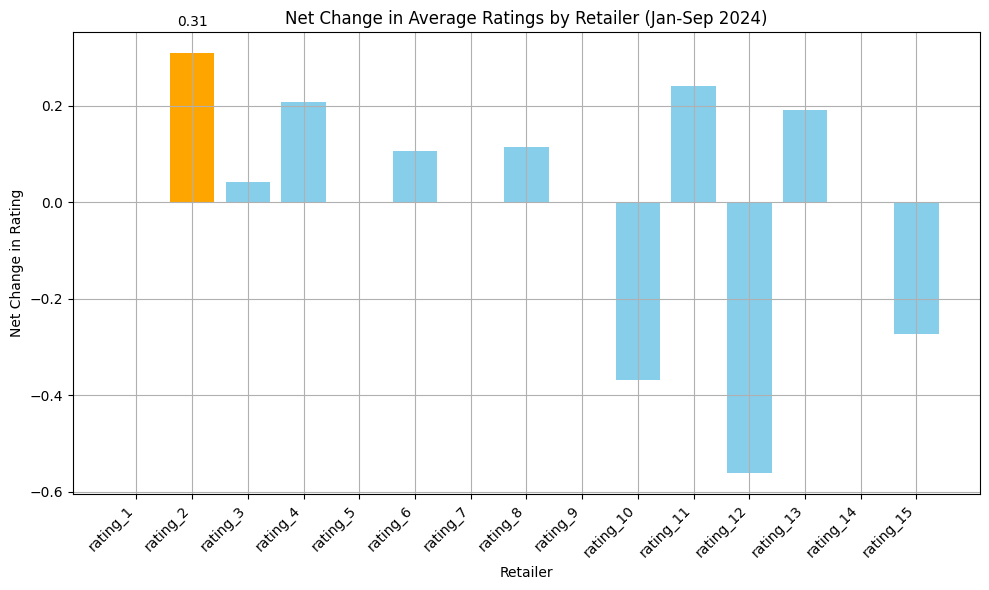

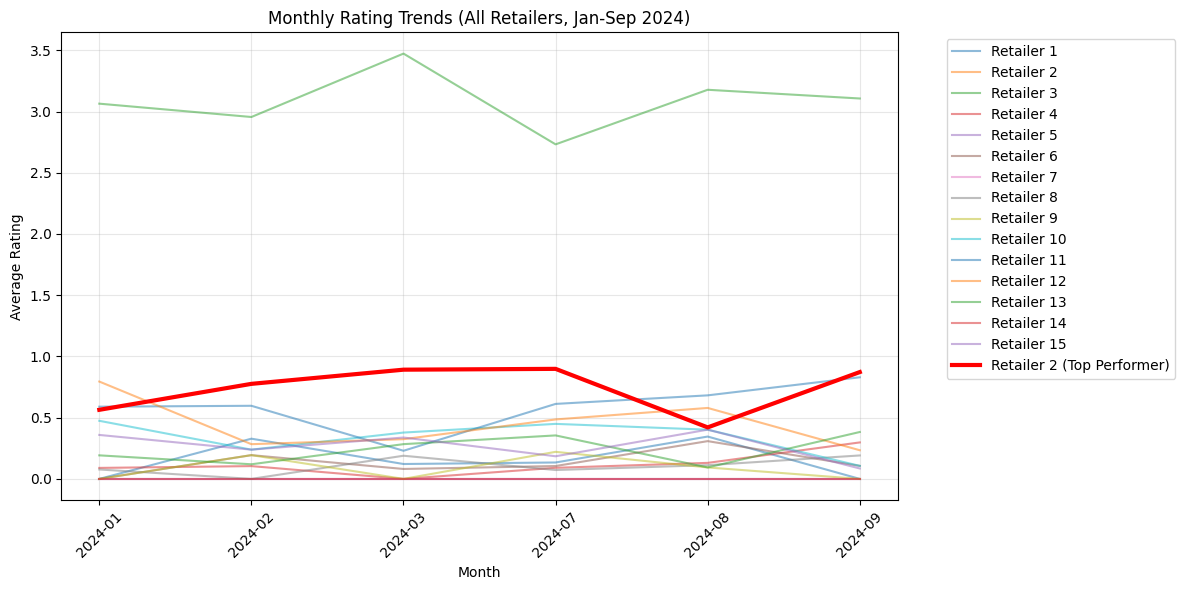

In [9]:
# Step 1: Calculate average monthly ratings for each retailer
avg_ratings_per_month = included_respondent.groupby('month')[rating_cols].mean().reset_index()
# print(avg_ratings_per_month)
# Step 2: Extract Jan and Sep rows for comparison
jan_ratings = avg_ratings_per_month[avg_ratings_per_month['month'] == '2024-01'].drop('month', axis=1).values
sep_ratings = avg_ratings_per_month[avg_ratings_per_month['month'] == '2024-09'].drop('month', axis=1).values

# Step 3: Compute rating change and identify top performer.
change_in_ratings = sep_ratings - jan_ratings
change_in_ratings_series = pd.Series(change_in_ratings.flatten(), index=avg_ratings_per_month.columns[1:])
print("Change in Ratings from Jan 2024 to Sep 2024:")
print(change_in_ratings_series)

highest_increase_retailer = change_in_ratings_series.idxmax()  # Retailer with the highest increase
highest_increase_value = change_in_ratings_series.max() 
print(f"The retailer with the highest increase in ratings is {highest_increase_retailer} with an increase of {highest_increase_value:.2f}")

#Step 4: Create a bar chart to visualize the changes in ratings for all retailers
plt.figure(figsize=(10, 6))
plt.bar(change_in_ratings_series.index, change_in_ratings_series.values, color='skyblue')

plt.bar(highest_increase_retailer, highest_increase_value, color='orange')

plt.title("Net Change in Average Ratings by Retailer (Jan-Sep 2024)")
plt.xlabel("Retailer")
plt.ylabel("Net Change in Rating")
plt.xticks(rotation=45, ha='right')
plt.text(highest_increase_retailer, highest_increase_value + 0.05, f'{highest_increase_value:.2f}', 
         ha='center', va='bottom', color='black')
plt.grid(True)
plt.tight_layout()
plt.savefig("rating_change_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 5: Create a line graph to visualize the trend over time for all retailers
sorted_changes = change_in_ratings_series.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
for retailer in range(1, 16):
    retailer_ratings = avg_ratings_per_month[f'rating_{retailer}']
    plt.plot(avg_ratings_per_month['month'], retailer_ratings, 
             label=f'Retailer {retailer}', alpha=0.5)

top_retailer = sorted_changes.index[0] 
top_retailer_num = int(top_retailer.split('_')[1])
plt.plot(avg_ratings_per_month['month'], 
         avg_ratings_per_month[f'rating_{top_retailer_num}'],
         label=f'Retailer {top_retailer_num} (Top Performer)', 
         linewidth=3, color='red')

plt.title("Monthly Rating Trends (All Retailers, Jan-Sep 2024)")
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("rating_trends_line.png", dpi=300, bbox_inches='tight')
plt.show()


'''Problem Statement 2: Pick the retailer with highest no. of respondents and create a performance summary report.'''


Number of respondents for each retailer (sorted from highest to lowest):
aware_3     384
aware_2      96
aware_11     63
aware_12     62
aware_10     53
aware_15     28
aware_13     23
aware_1      22
aware_6      15
aware_9      14
aware_4      12
aware_8       9
aware_5       0
aware_7       0
aware_14      0
dtype: int64
The retailer with the highest number of respondents is aware_3 with 384 responses.


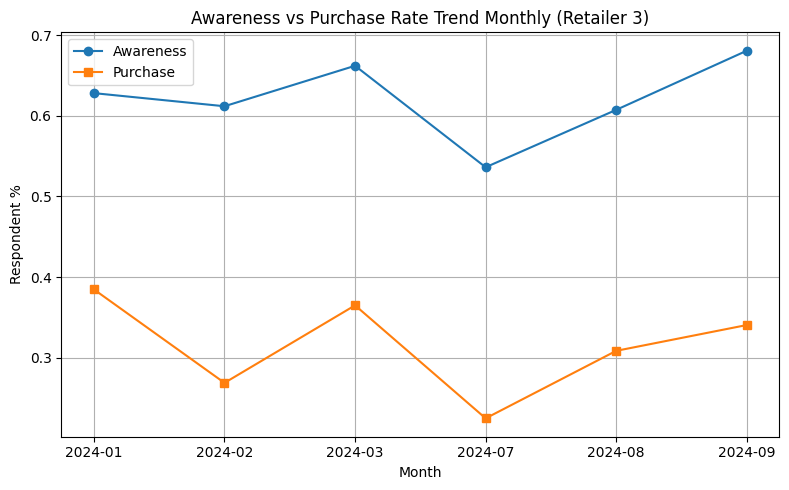

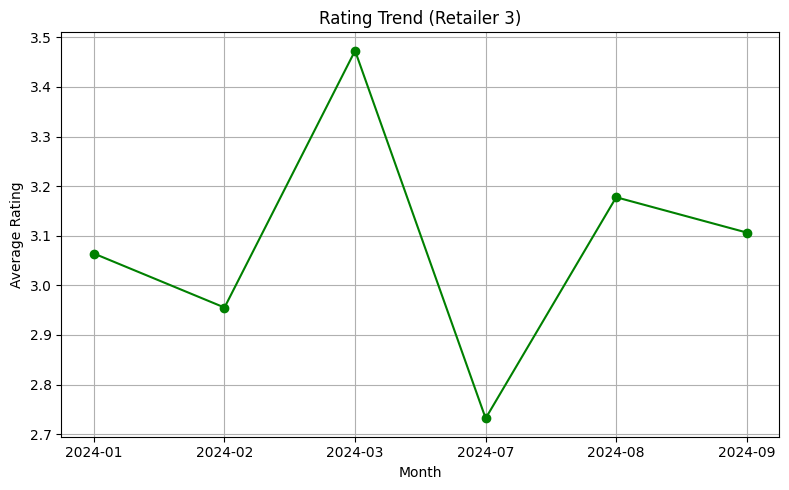

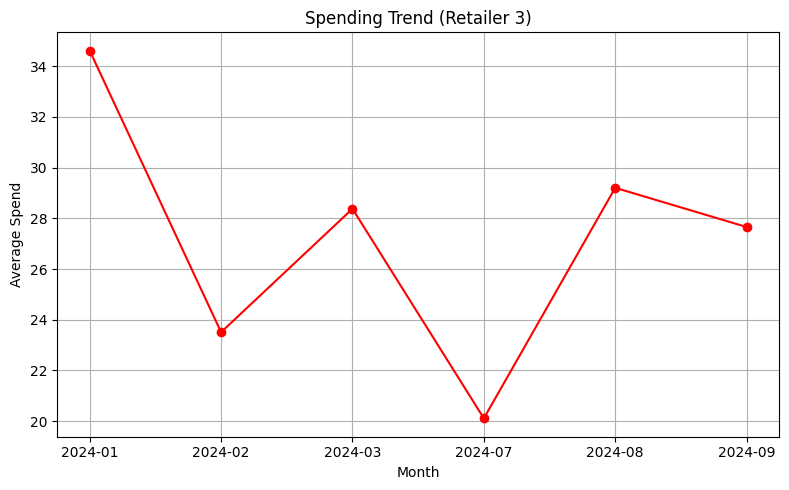

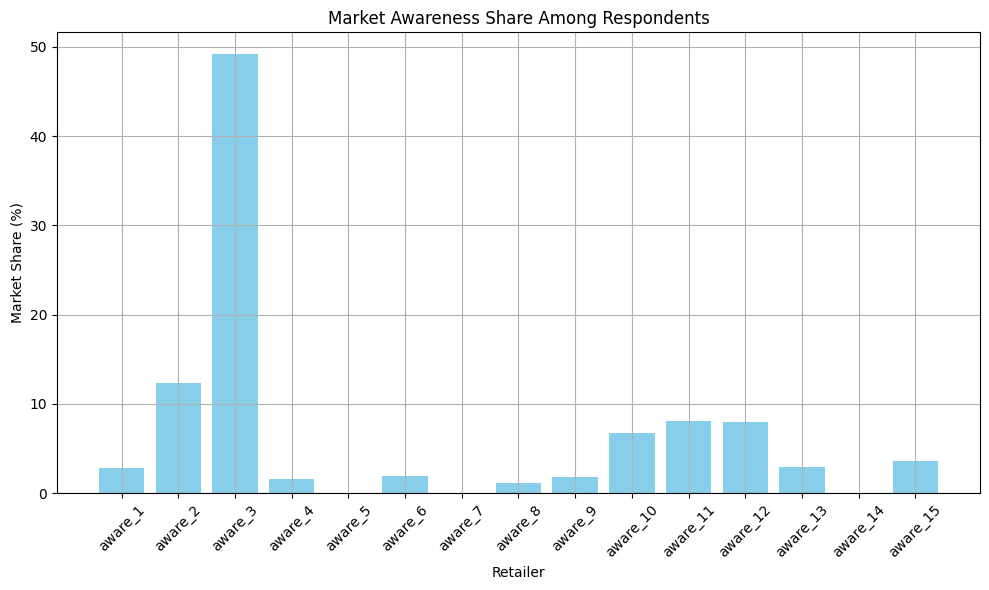

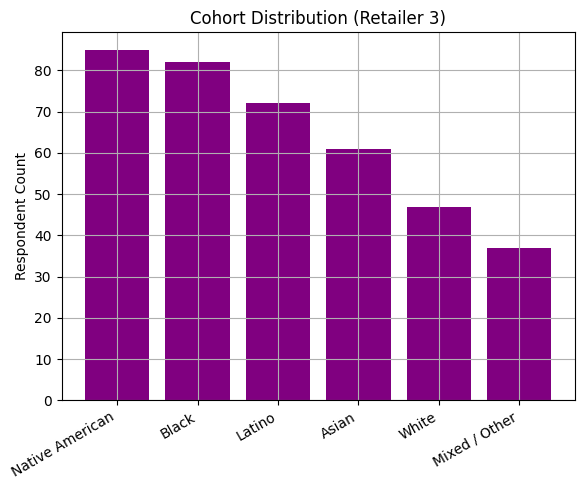

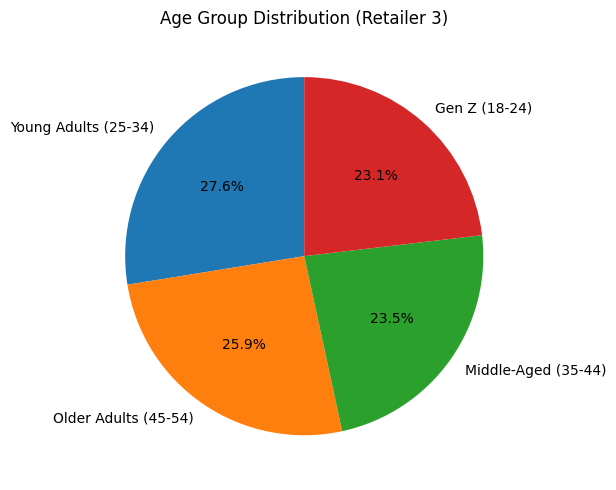

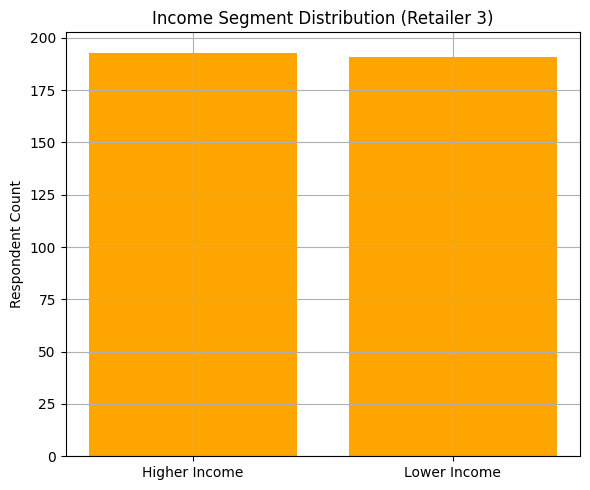


Key Performance Indicators (Retailer 3):
Average Awareness: 0.62
Average Purchase Rate: 0.32
Average Rating: 3.08
Average Spend: $27.25
Conversion Rate (Awareness to Purchase): 50.48%

KPI Comparison (Retailer 3 vs Others - Raw Values):
Metric               Retailer 3      Avg Others     
--------------------------------------------------
Awareness            0.62           0.04
Purchase Rate        0.32           0.02
Rating               3.08           0.24
Spend                $27.25         $1.68
Conversion Rate      50.48%        43.07%

KPI Comparison: Retailer 3 vs All Others
KPI                  Retailer 3      Others (Avg)   
--------------------------------------------------
Awareness             62.11%        4.37%
Purchase Rate         31.53%        1.88%
Rating                 3.08        0.24
Spend                $ 27.25      $  1.68
Conversion Rate       50.48%       43.07%


In [10]:
# === Step 1: Identify Retailer with Highest Awareness ===
respondents_per_retailer = included_respondent[[f'aware_{i}' for i in range(1, 16)]].sum()
sorted_retailers = respondents_per_retailer.sort_values(ascending=False)
print("\nNumber of respondents for each retailer (sorted from highest to lowest):")
print(sorted_retailers)
top_retailer = respondents_per_retailer.idxmax()
top_retailer_num_by_awareness =  int(top_retailer.split('_')[1])
top_retailer_responses = respondents_per_retailer.max()
total_respondents = respondents_per_retailer.sum()
print(f"The retailer with the highest number of respondents is {top_retailer} with {top_retailer_responses} responses.")

# === Step 2: Awareness & Purchase Trend ===
awareness_trend = included_respondent.groupby('month')[f'aware_{top_retailer_num_by_awareness}'].mean()
purchase_trend = included_respondent.groupby('month')[f'purchp6m_{top_retailer_num_by_awareness}'].mean()

plt.figure(figsize=(8, 5))
plt.plot(awareness_trend.index, awareness_trend.values, marker='o', label='Awareness')
plt.plot(purchase_trend.index, purchase_trend.values, marker='s', label='Purchase')
plt.title('Awareness vs Purchase Rate Trend Monthly (Retailer 3)')
plt.xlabel('Month')
plt.ylabel('Respondent %')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("ret3_awareness_purchase.png", dpi=300)
plt.show()

# === Step 3: Rating Trend ===
rating_trend = included_respondent.groupby('month')[f'rating_{top_retailer_num_by_awareness}'].mean()

plt.figure(figsize=(8, 5))
plt.plot(rating_trend.index, rating_trend.values, marker='o', color='green')
plt.title('Rating Trend (Retailer 3)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.savefig("ret3_rating_trend.png", dpi=300)
plt.show()

# === Step 4: Spending Trend ===
spend_trend = included_respondent.groupby('month')[f'amtspend_{top_retailer_num_by_awareness}'].mean()

plt.figure(figsize=(8, 5))
plt.plot(spend_trend.index, spend_trend.values, marker='o', color='red')
plt.title('Spending Trend (Retailer 3)')
plt.xlabel('Month')
plt.ylabel('Average Spend')
plt.grid(True)
plt.tight_layout()
plt.savefig("ret3_spending_trend.png", dpi=300)
plt.show()

# === Step 5: Market Share by Awareness ===
market_share = (respondents_per_retailer / total_respondents * 100).round(2)

plt.figure(figsize=(10, 6))
plt.bar(market_share.index, market_share.values, color='skyblue')
plt.title('Market Awareness Share Among Respondents')
plt.xlabel('Retailer')
plt.ylabel('Market Share (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("ret3_market_share.png", dpi=300)
plt.show()

# === Step 6: Demographic Analysis ===

# Cohort Distribution
cohort_dist = included_respondent[included_respondent[f'aware_{top_retailer_num_by_awareness}'] > 0]['Cohort'].map(cohort_map).value_counts()
plt.figure(figsize=(6, 5))
labels = list(cohort_dist.keys())
plt.bar(cohort_dist.index, cohort_dist.values, color='purple')
plt.title('Cohort Distribution (Retailer 3)')
plt.ylabel('Respondent Count')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig("ret3_cohort_distribution.png", dpi=300)
plt.show()

# Age Group Distribution
age_dist = included_respondent[included_respondent[f'aware_{top_retailer_num_by_awareness}'] > 0]['Age Group'].map(age_group_map).value_counts()
plt.figure(figsize=(6, 5))
plt.pie(age_dist.values, labels=age_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Age Group Distribution (Retailer 3)')
plt.tight_layout()
plt.savefig("ret3_age_group_distribution.png", dpi=300)
plt.show()

# Income Segment Distribution
seg_dist = included_respondent[included_respondent[f'aware_{top_retailer_num_by_awareness}'] > 0]['Segment'].map(income_map).value_counts()
plt.figure(figsize=(6, 5))
plt.bar(seg_dist.index, seg_dist.values, color='orange')
plt.title('Income Segment Distribution (Retailer 3)')
plt.ylabel('Respondent Count')
plt.grid(True)
plt.tight_layout()
plt.savefig("ret3_segment_distribution.png", dpi=300)
plt.show()

# === Step 7: KPI Calculation ===
avg_awareness = awareness_trend.mean()
avg_purchase = purchase_trend.mean()
avg_rating = rating_trend.mean()
avg_spend = spend_trend.mean()
conversion_rate = (purchase_trend / awareness_trend * 100).mean()

print("\nKey Performance Indicators (Retailer 3):")
print(f"Average Awareness: {avg_awareness:.2f}")
print(f"Average Purchase Rate: {avg_purchase:.2f}")
print(f"Average Rating: {avg_rating:.2f}")
print(f"Average Spend: ${avg_spend:.2f}")
print(f"Conversion Rate (Awareness to Purchase): {conversion_rate:.2f}%")

# === Step 8: KPI Comparison with Other Retailers (raw)===
other_awareness = included_respondent[[f'aware_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_purchase = included_respondent[[f'purchp6m_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_rating = included_respondent[[f'rating_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_spend = included_respondent[[f'amtspend_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_conversion = (other_purchase / other_awareness * 100) if other_awareness != 0 else 0

print("\nKPI Comparison (Retailer 3 vs Others - Raw Values):")
print(f"{'Metric':<20} {'Retailer 3':<15} {'Avg Others':<15}")
print(f"{'-'*50}")
print(f"{'Awareness':<20} {avg_awareness:.2f}           {other_awareness:.2f}")
print(f"{'Purchase Rate':<20} {avg_purchase:.2f}           {other_purchase:.2f}")
print(f"{'Rating':<20} {avg_rating:.2f}           {other_rating:.2f}")
print(f"{'Spend':<20} ${avg_spend:.2f}         ${other_spend:.2f}")
print(f"{'Conversion Rate':<20} {conversion_rate:.2f}%        {other_conversion:.2f}%")


# KPI Comparison with Other Retailers (%)
other_awareness = included_respondent[[f'aware_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_purchase = included_respondent[[f'purchp6m_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_rating = included_respondent[[f'rating_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_spend = included_respondent[[f'amtspend_{i}' for i in range(1, 16) if i != top_retailer_num_by_awareness]].mean().mean()
other_conversion = (other_purchase / other_awareness) * 100 if other_awareness != 0 else 0

print("\nKPI Comparison: Retailer 3 vs All Others")
print(f"{'KPI':<20} {'Retailer 3':<15} {'Others (Avg)':<15}")
print(f"{'-'*50}")
print(f"{'Awareness':<20} {avg_awareness*100:>6.2f}%{'':<5} {other_awareness*100:>6.2f}%")
print(f"{'Purchase Rate':<20} {avg_purchase*100:>6.2f}%{'':<5} {other_purchase*100:>6.2f}%")
print(f"{'Rating':<20} {avg_rating:>6.2f}{'':<5} {other_rating:>6.2f}")
print(f"{'Spend':<20} ${avg_spend:>6.2f}{'':<5} ${other_spend:>6.2f}")
print(f"{'Conversion Rate':<20} {conversion_rate:>6.2f}%{'':<5} {other_conversion:>6.2f}%")



'''Problem statement 3: Has there been any change in trend of retailer performance compared with CPI (Consumer Price Index) for United States?'''

C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  all_metrics[f"{metric}_change_{i}"] = aligned_series.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  all_metrics[f"{metric}_change_{i}"] = aligned_series.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values 


Best KPI to explain CPI sensitivity:
Metric: Rating | Retailer: 11 | Correlation: 0.484


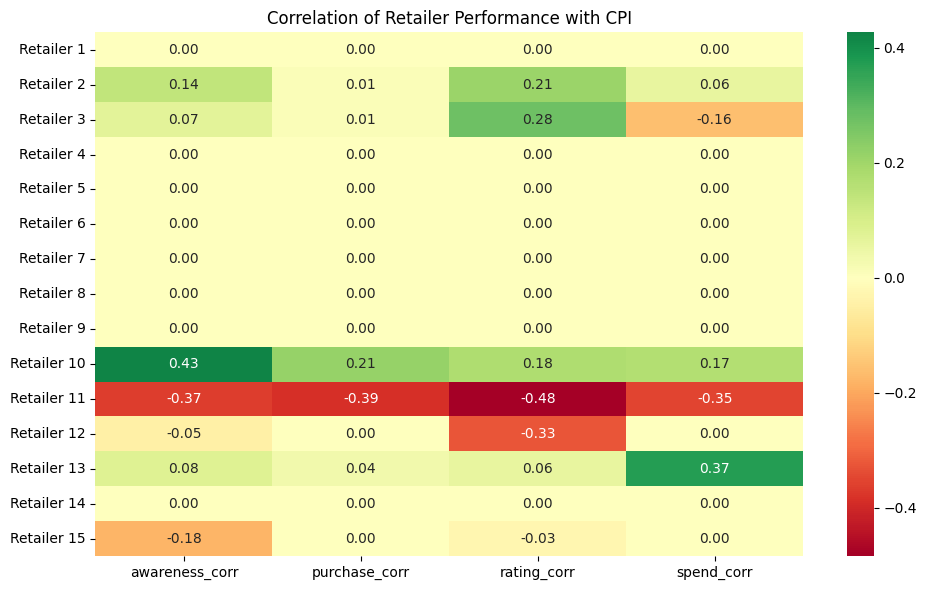

C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:74: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retailer_metrics[f"{metric}_change"] = aligned.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:74: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retailer_metrics[f"{metric}_change"] = aligned.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:74: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to cal

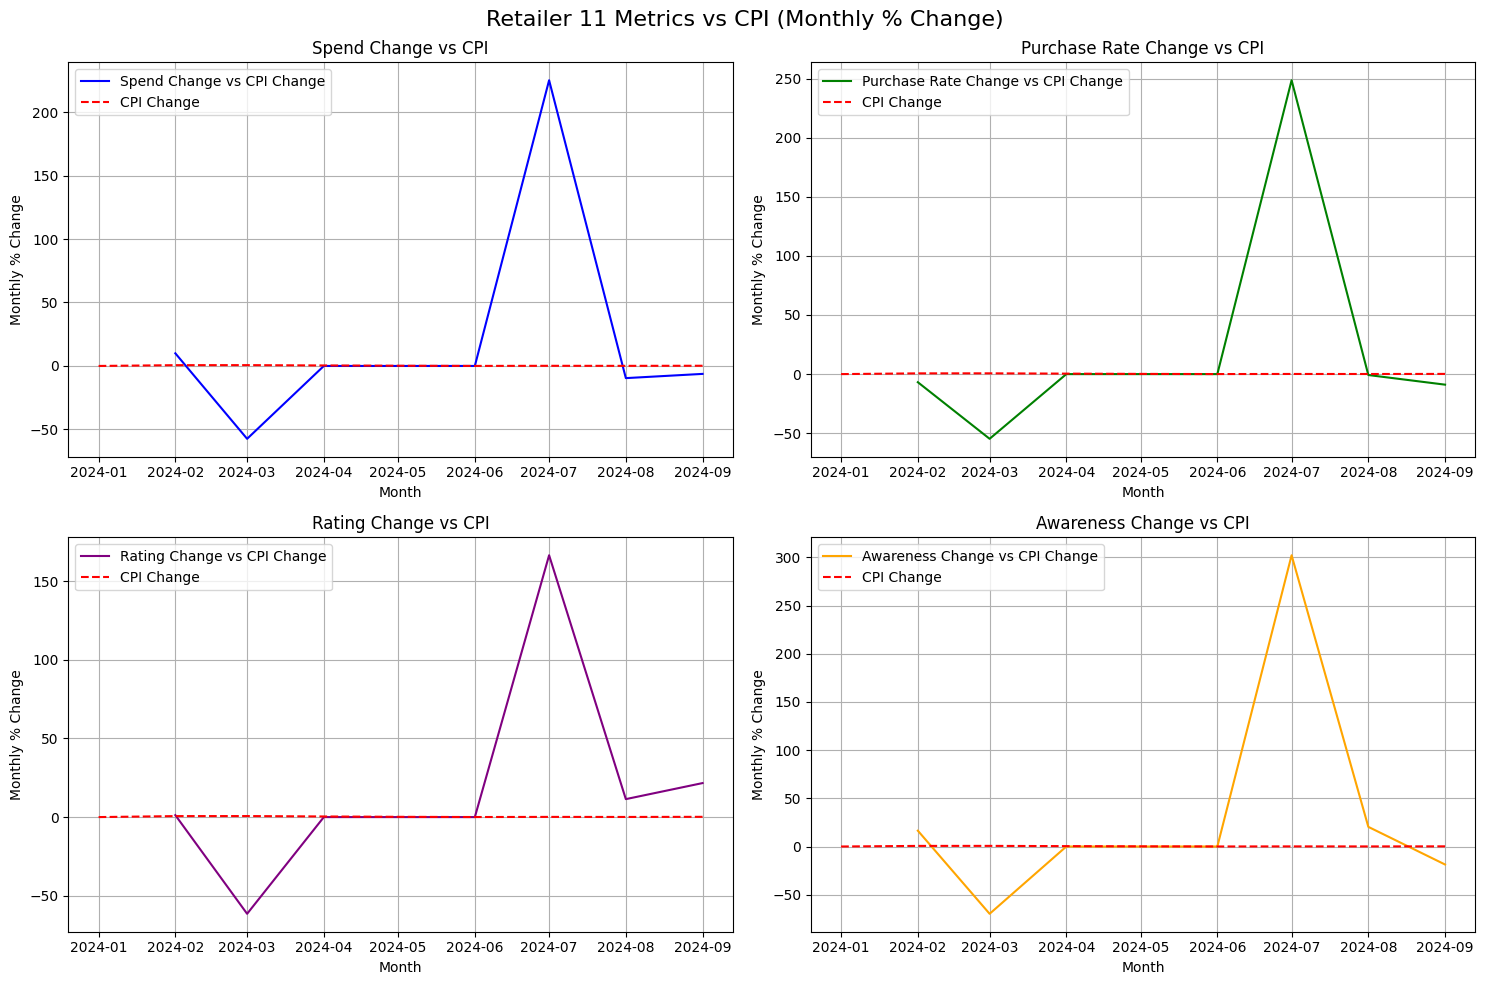

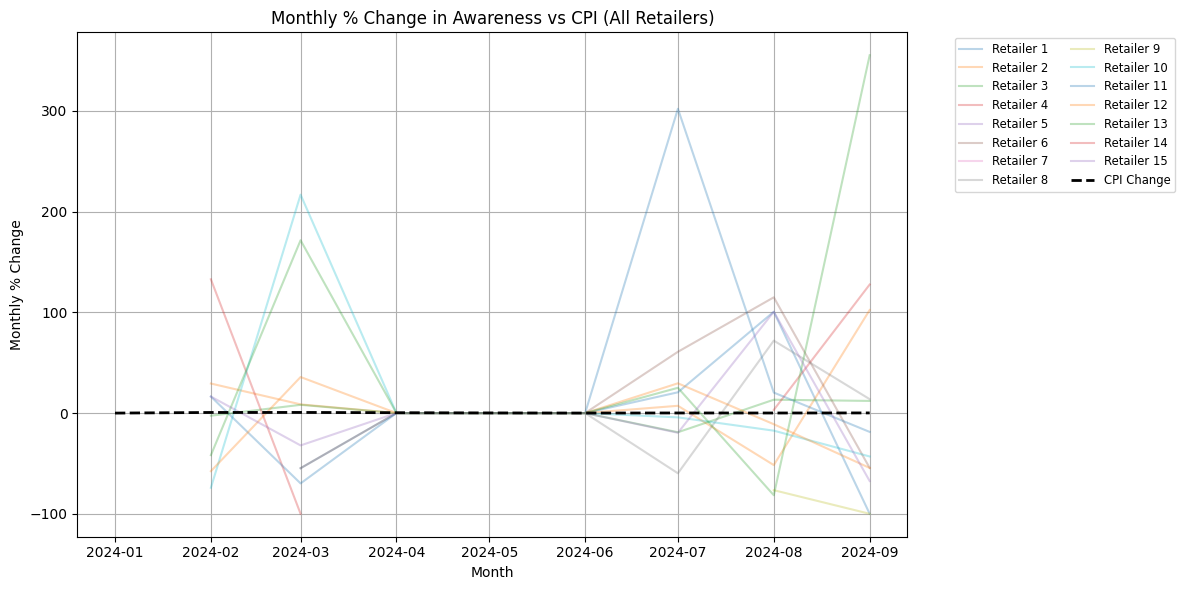

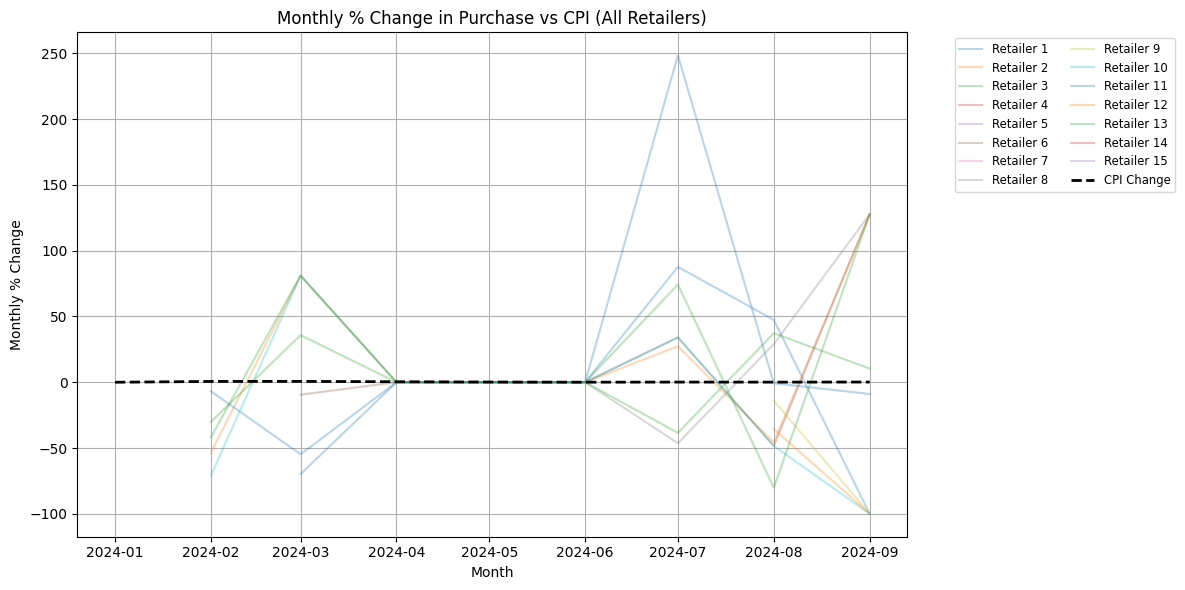

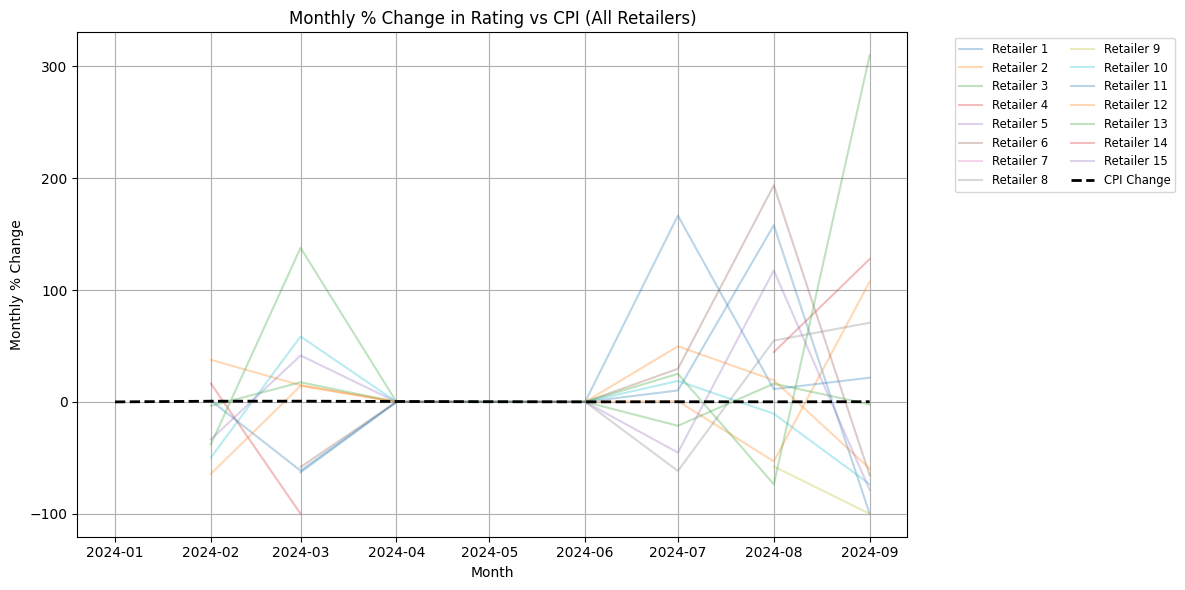

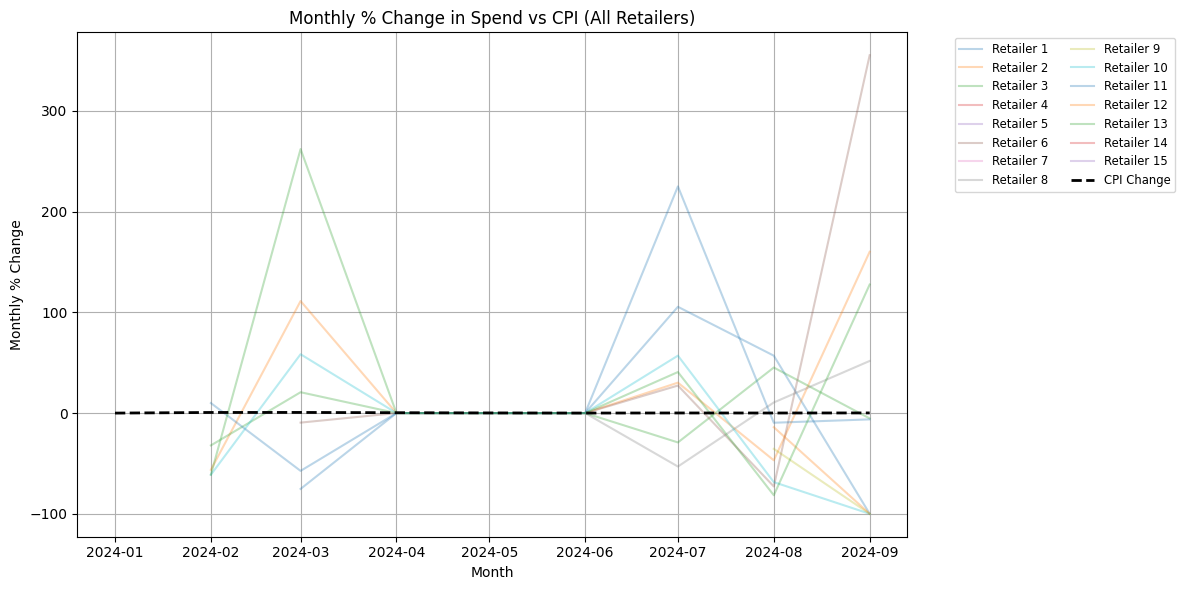

C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:123: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retailer3_metrics[f"{metric}_change"] = aligned.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:123: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retailer3_metrics[f"{metric}_change"] = aligned.pct_change() * 100
C:\Users\monal\AppData\Local\Temp\ipykernel_25260\1079514818.py:123: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior t


Correlation of Retailer 3 metrics with CPI:
awareness_change vs CPI: 0.069
purchase_change vs CPI: 0.013
rating_change vs CPI: 0.277
spend_change vs CPI: -0.161


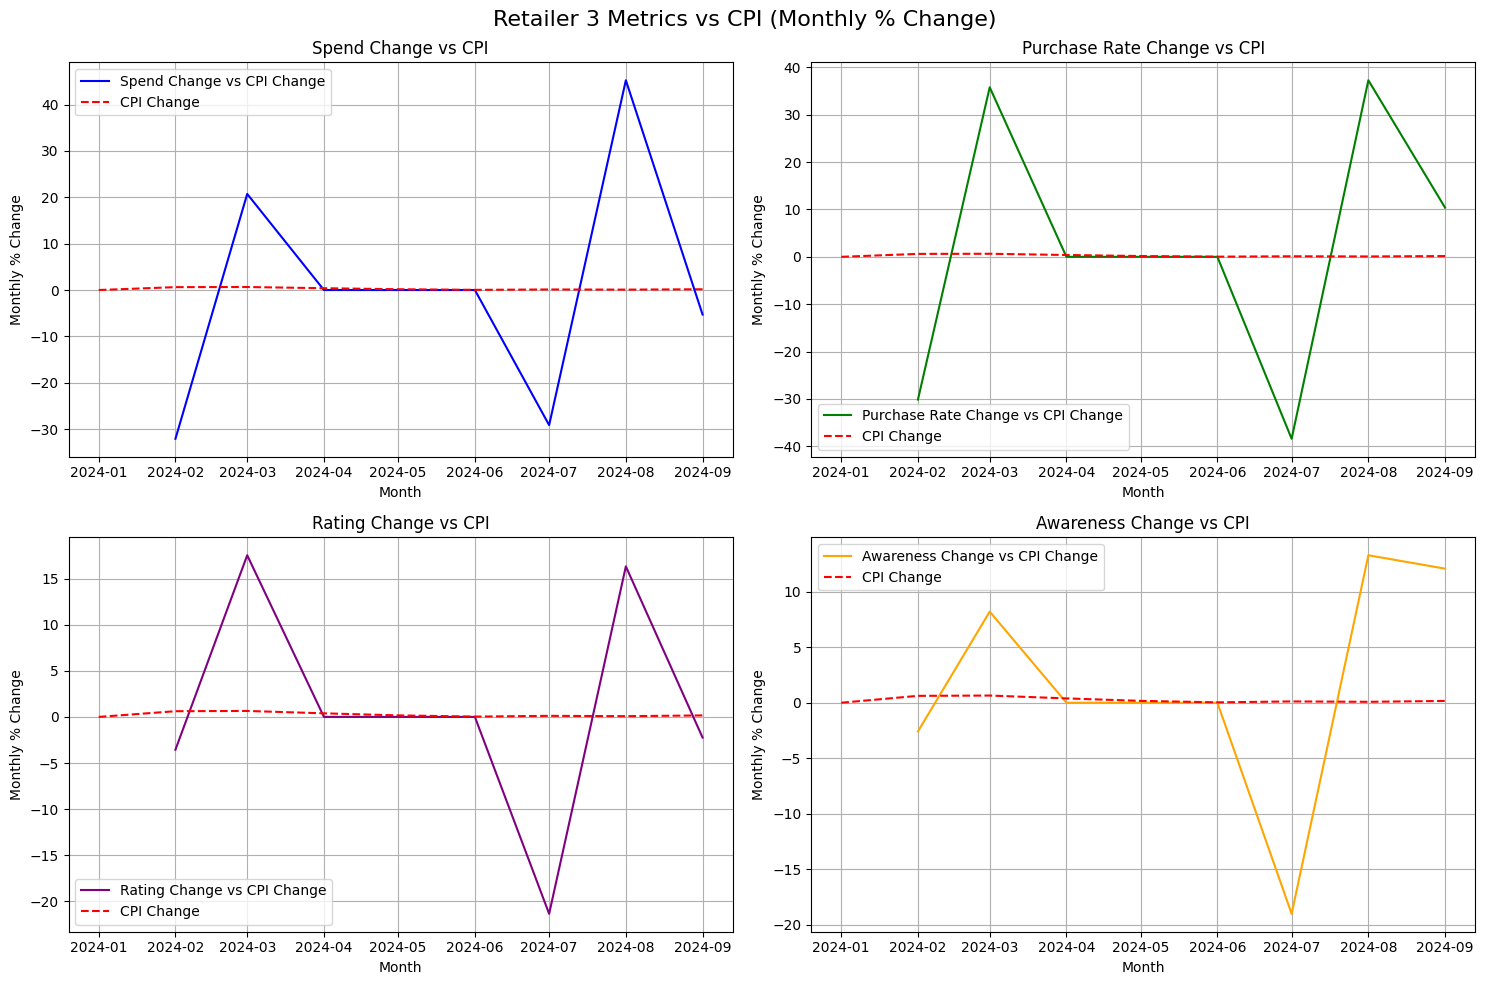

In [11]:
# Retailer vs CPI Sensitivity Analysis
# Identify the retailer most sensitive to inflation (CPI) and visualize all 4 KPIs

# Step 1: Fetch US CPI data
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2024, 9, 30)
cpi_data = web.DataReader('CPIAUCNS', 'fred', start, end)
cpi_data['CPI_Change'] = cpi_data['CPIAUCNS'].pct_change() * 100
cpi_data['CPI_Change'] = cpi_data['CPI_Change'].fillna(0)
cpi_data.index = pd.to_datetime(cpi_data.index)

# Step 2: Compute % change metrics for each retailer
metrics_list = ['awareness', 'purchase', 'rating', 'spend']
column_prefix = {
    'awareness': 'aware',
    'purchase': 'purchp6m',
    'rating': 'rating',
    'spend': 'amtspend'
}

all_metrics = pd.DataFrame(index=cpi_data.index)

for metric in metrics_list:
    for i in range(1, 16):
        col_name = f"{column_prefix[metric]}_{i}"
        if col_name in included_respondent.columns:
            monthly_avg = included_respondent.groupby('month_dt')[col_name].mean()
            aligned_series = monthly_avg.reindex(cpi_data.index, fill_value=np.nan)
            all_metrics[f"{metric}_change_{i}"] = aligned_series.pct_change() * 100

# Step 3: Identify the most CPI-sensitive retailer and metric
correlation_summary = pd.DataFrame(index=[f"Retailer {i}" for i in range(1, 16)])

best_metric = None
best_retailer = None
max_corr = 0

for metric in metrics_list:
    correlations = []
    for i in range(1, 16):
        col = f"{metric}_change_{i}"
        if col in all_metrics.columns:
            corr = all_metrics[col].corr(cpi_data['CPI_Change'])
            correlations.append(corr)
            if abs(corr) > max_corr:
                max_corr = abs(corr)
                best_metric = metric
                best_retailer = i
        else:
            correlations.append(None)
    correlation_summary[f"{metric}_corr"] = correlations

print(f"\nBest KPI to explain CPI sensitivity:")
print(f"Metric: {best_metric.title()} | Retailer: {best_retailer} | Correlation: {max_corr:.3f}")

# Step 4: Heatmap of all retailer correlations with CPI
plt.figure(figsize=(10, 6))
heatmap_data = correlation_summary.fillna(0.0).astype(float)
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
# sns.heatmap(correlation_summary.astype(float), annot=True, cmap='RdYlGn', center=0)
plt.title("Correlation of Retailer Performance with CPI")
plt.tight_layout()
plt.savefig("all_retailers_cpi_correlation_heatmap.png", dpi=300)
plt.show()

# Step 5: Plot all 4 KPIs for the most CPI-sensitive retailer
retailer_metrics = pd.DataFrame()
for metric in metrics_list:
    col = f"{column_prefix[metric]}_{best_retailer}"
    if col in included_respondent.columns:
        monthly_avg = included_respondent.groupby('month_dt')[col].mean()
        aligned = monthly_avg.reindex(cpi_data.index)
        retailer_metrics[metric] = aligned
        retailer_metrics[f"{metric}_change"] = aligned.pct_change() * 100

plt.figure(figsize=(15, 10))
plt.suptitle(f'Retailer {best_retailer} Metrics vs CPI (Monthly % Change)', fontsize=16)
# titles = ['Spending', 'Purchases', 'Ratings', 'Awareness']
titles = ['Spend Change vs CPI', 'Purchase Rate Change vs CPI', 'Rating Change vs CPI', 'Awareness Change vs CPI']
colors = ['blue', 'green', 'purple', 'orange']
metrics_plot = ['spend_change', 'purchase_change', 'rating_change', 'awareness_change']

for i, metric in enumerate(metrics_plot):
    plt.subplot(2, 2, i+1)
    if metric in retailer_metrics.columns:
        plt.plot(retailer_metrics.index, retailer_metrics[metric], label=f'{titles[i]} Change', color=colors[i])
    plt.plot(cpi_data.index, cpi_data['CPI_Change'], 'r--', label='CPI Change')
    plt.title(f'{titles[i]}')
    plt.xlabel('Month')
    plt.ylabel('Monthly % Change')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("most_sensitive_retailer_vs_cpi.png", dpi=300)
plt.show()

# Step 6: Plot all retailers per metric vs CPI
for j, metric in enumerate(metrics_list):
    plt.figure(figsize=(12, 6))
    plt.title(f'Monthly % Change in {metric.title()} vs CPI (All Retailers)')
    for i in range(1, 16):
        col = f"{metric}_change_{i}"
        if col in all_metrics.columns:
            plt.plot(all_metrics.index, all_metrics[col], alpha=0.3, label=f'Retailer {i}')
    plt.plot(cpi_data.index, cpi_data['CPI_Change'], 'k--', linewidth=2, label='CPI Change')
    plt.xlabel('Month')
    plt.ylabel('Monthly % Change')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"all_retailers_{metric}_vs_cpi.png", dpi=300)
    plt.show()

# Step 7: Retailer 3 Metrics Comparison
retailer3_metrics = pd.DataFrame()
for metric in metrics_list:
    col = f"{column_prefix[metric]}_3"
    if col in included_respondent.columns:
        monthly_avg = included_respondent.groupby('month_dt')[col].mean()
        aligned = monthly_avg.reindex(cpi_data.index)
        retailer3_metrics[metric] = aligned
        retailer3_metrics[f"{metric}_change"] = aligned.pct_change() * 100

print("\nCorrelation of Retailer 3 metrics with CPI:")
for metric in metrics_list:
    col = f"{metric}_change"
    if col in retailer3_metrics.columns:
        corr = retailer3_metrics[col].corr(cpi_data['CPI_Change'])
        print(f"{col} vs CPI: {corr:.3f}")

plt.figure(figsize=(15, 10))
plt.suptitle('Retailer 3 Metrics vs CPI (Monthly % Change)', fontsize=16)

for i, metric in enumerate(metrics_plot):
    plt.subplot(2, 2, i+1)
    if metric in retailer3_metrics.columns:
        plt.plot(retailer3_metrics.index, retailer3_metrics[metric], label=f'{titles[i]} Change', color=colors[i])
    plt.plot(cpi_data.index, cpi_data['CPI_Change'], label='CPI Change', linestyle='--', color='red')
    plt.title(f'{titles[i]}')
    plt.xlabel('Month')
    plt.ylabel('Monthly % Change')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("retailer3_vs_cpi.png", dpi=300)
plt.show()

